<h1><strong>Weather Prediction Experiment</strong></h1>
<p>In this experiment, we will use the first time step to predict the entire trajectory.</p>

In [1]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<module 'score' from '/home/mtemoschenko/TFE/score.py'>

<h2>Load Model</h2>

In [2]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth"

In [3]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)
channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

Using device: cuda


Channels : 24


In [4]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_1903291/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth, trained until epoch 310


<h2>Define First Time Step Operator A(x)</h2>

In [ ]:
def first_timestep(batch, mask):
    """Extract only the first timestep from the batch and replicate it across all timesteps."""
    if batch.ndim == 4:
        batch = batch.unsqueeze(0)
    S, B, C, H, W = batch.shape
    num_variables = 2  # T2m and U10m
    window = C // num_variables
    batch_reshaped = batch.view(S, B, window, num_variables, H, W)
    first_step = batch_reshaped[:, :, 0, :, :, :] # (S,B, 1, num_variables,H,W)
    first_step = first_step.squeeze(2)
    return first_step * mask

def A(x):
    return first_timestep(x, mask)

torch.Size([1, 5, 2, 64, 64])
torch.Size([10, 24, 64, 64])
T2m  Mean : 9.293136596679688, Var: 2.4827427864074707
U10m  Mean : 2.456944465637207, Var: 0.9416964650154114
T2m  Mean : 4.495140075683594, Var: 0.863133430480957
U10m  Mean : 2.18533992767334, Var: 1.0518693923950195
T2m  Mean : 17.812273025512695, Var: 1.95548677444458
U10m  Mean : 3.711236000061035, Var: 1.2997891902923584
T2m  Mean : 18.769779205322266, Var: 1.9984430074691772
U10m  Mean : 4.268828868865967, Var: 1.2315641641616821


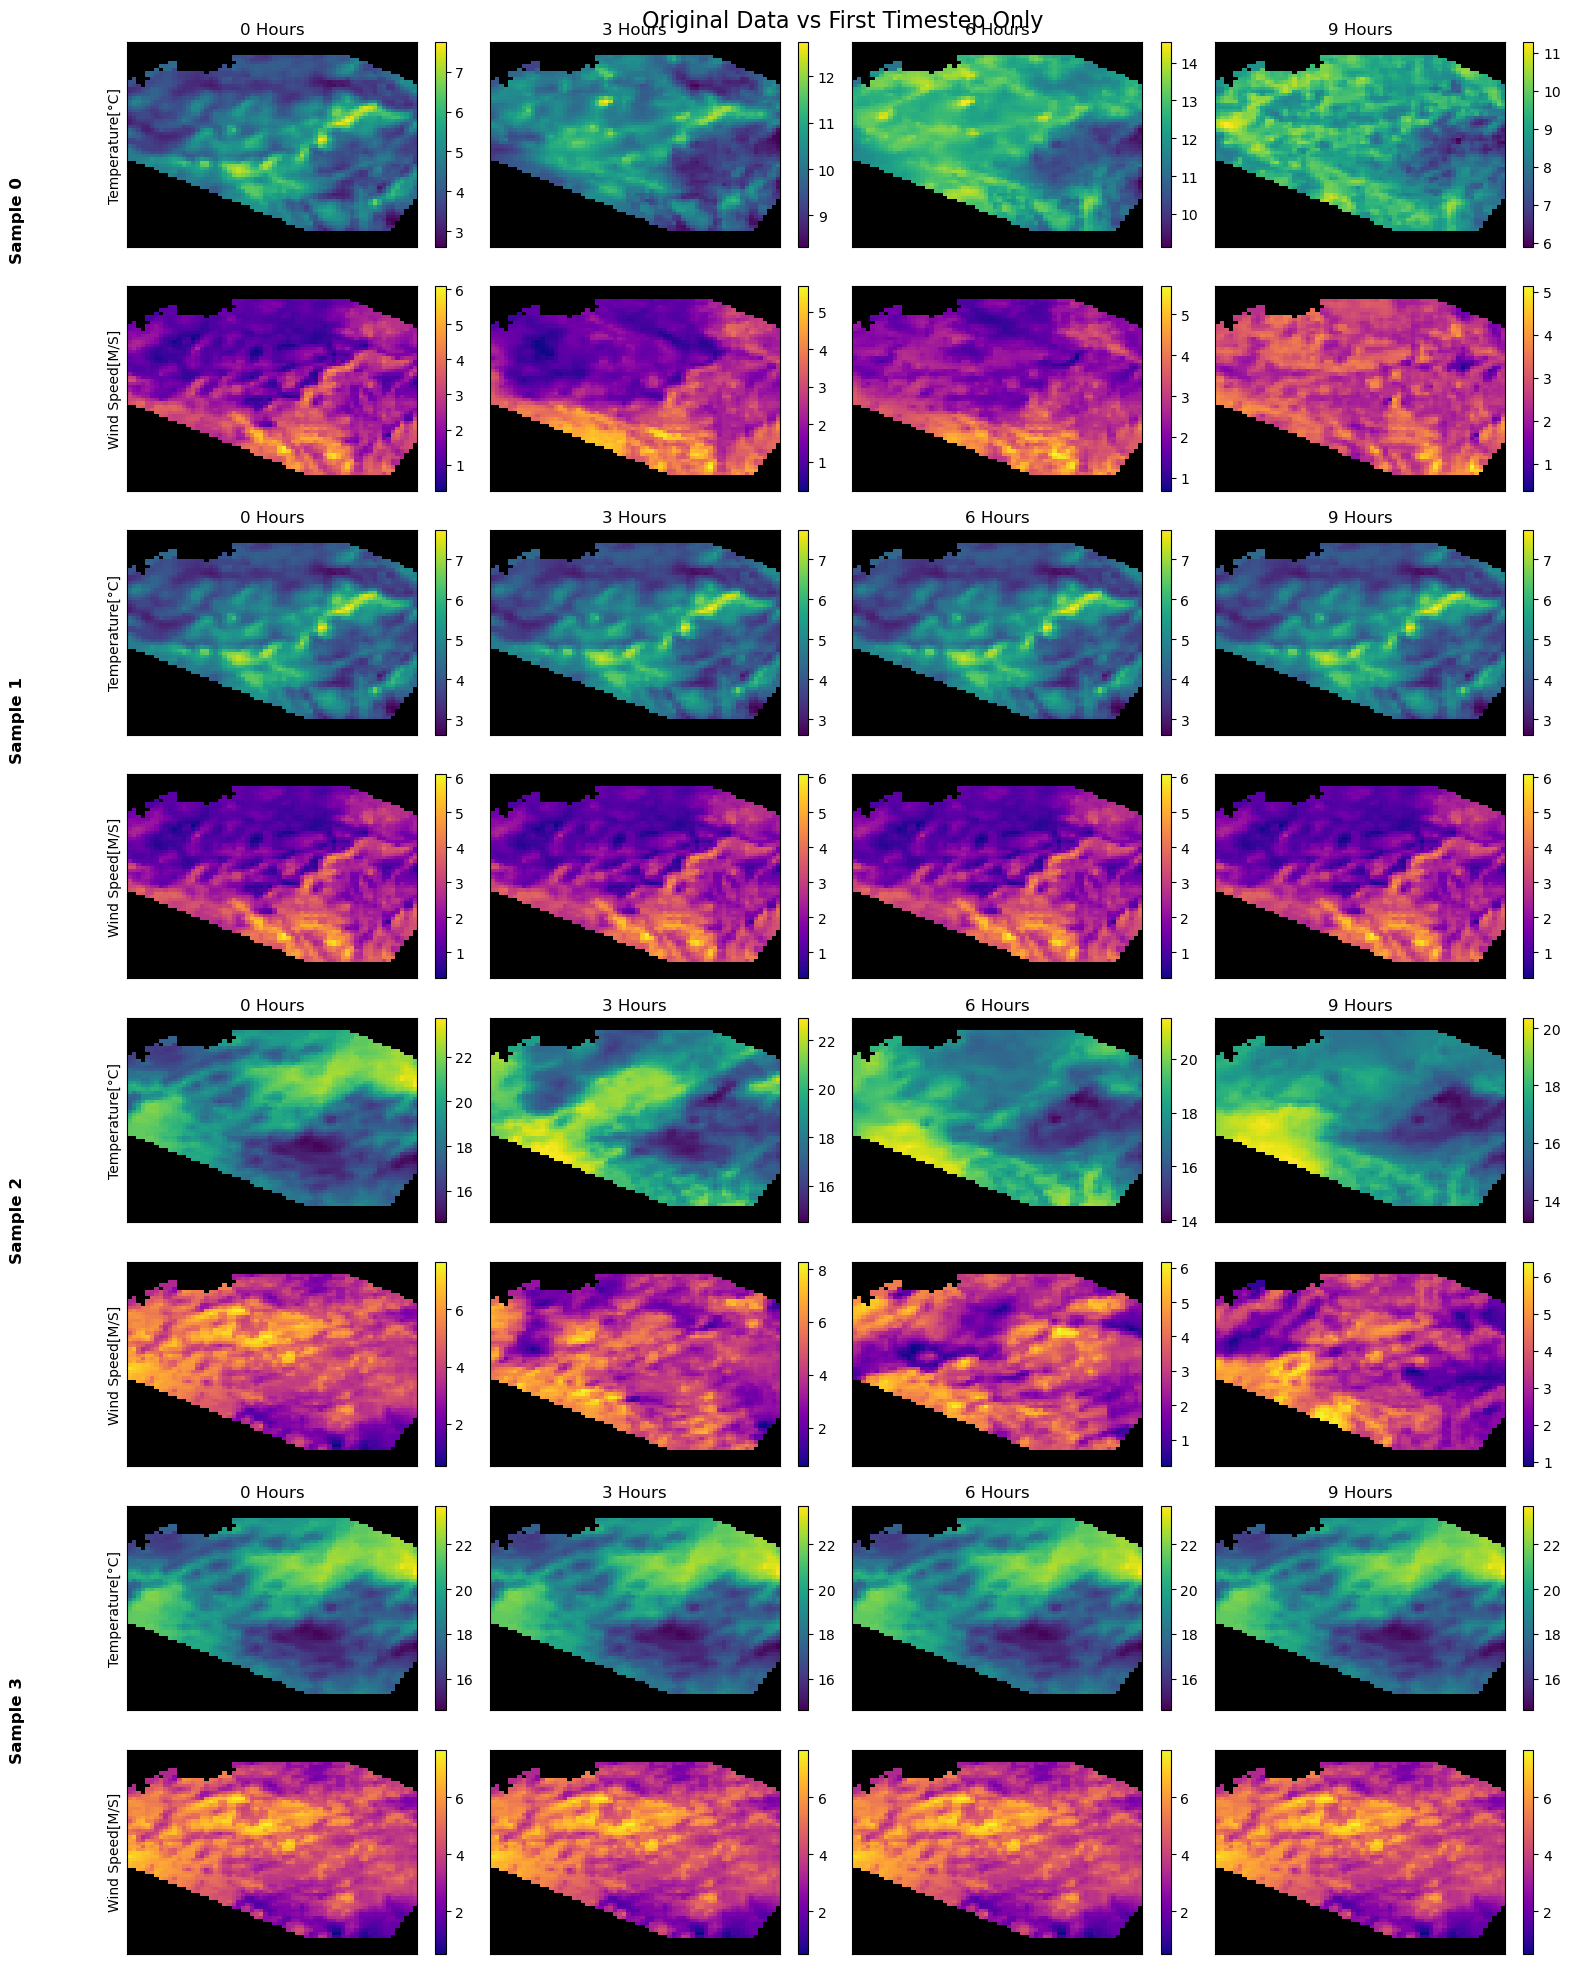

In [6]:

batch, dic = next(iter(testloader))
batch = batch.to(device)
first_step_data = A(batch)
print(first_step_data.shape)
window = 12
repeated_data = first_step_data.repeat(1, 1,window, 1, 1)
new_tensor = torch.stack((batch.cpu(), repeated_data.squeeze(0).cpu()), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor, info, mask_cpu, samples=4, step=3, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Original Data vs First Timestep Only", fontsize=16)
plt.tight_layout()

<h2>Prediction Experiment</h2>

torch.Size([10, 24, 64, 64])
T2m  Mean : 13.783927917480469, Var: 0.9493104219436646
U10m  Mean : 4.889293670654297, Var: 1.170600414276123
T2m  Mean : 14.251411437988281, Var: 1.1749553680419922
U10m  Mean : 4.944182395935059, Var: 1.3414905071258545


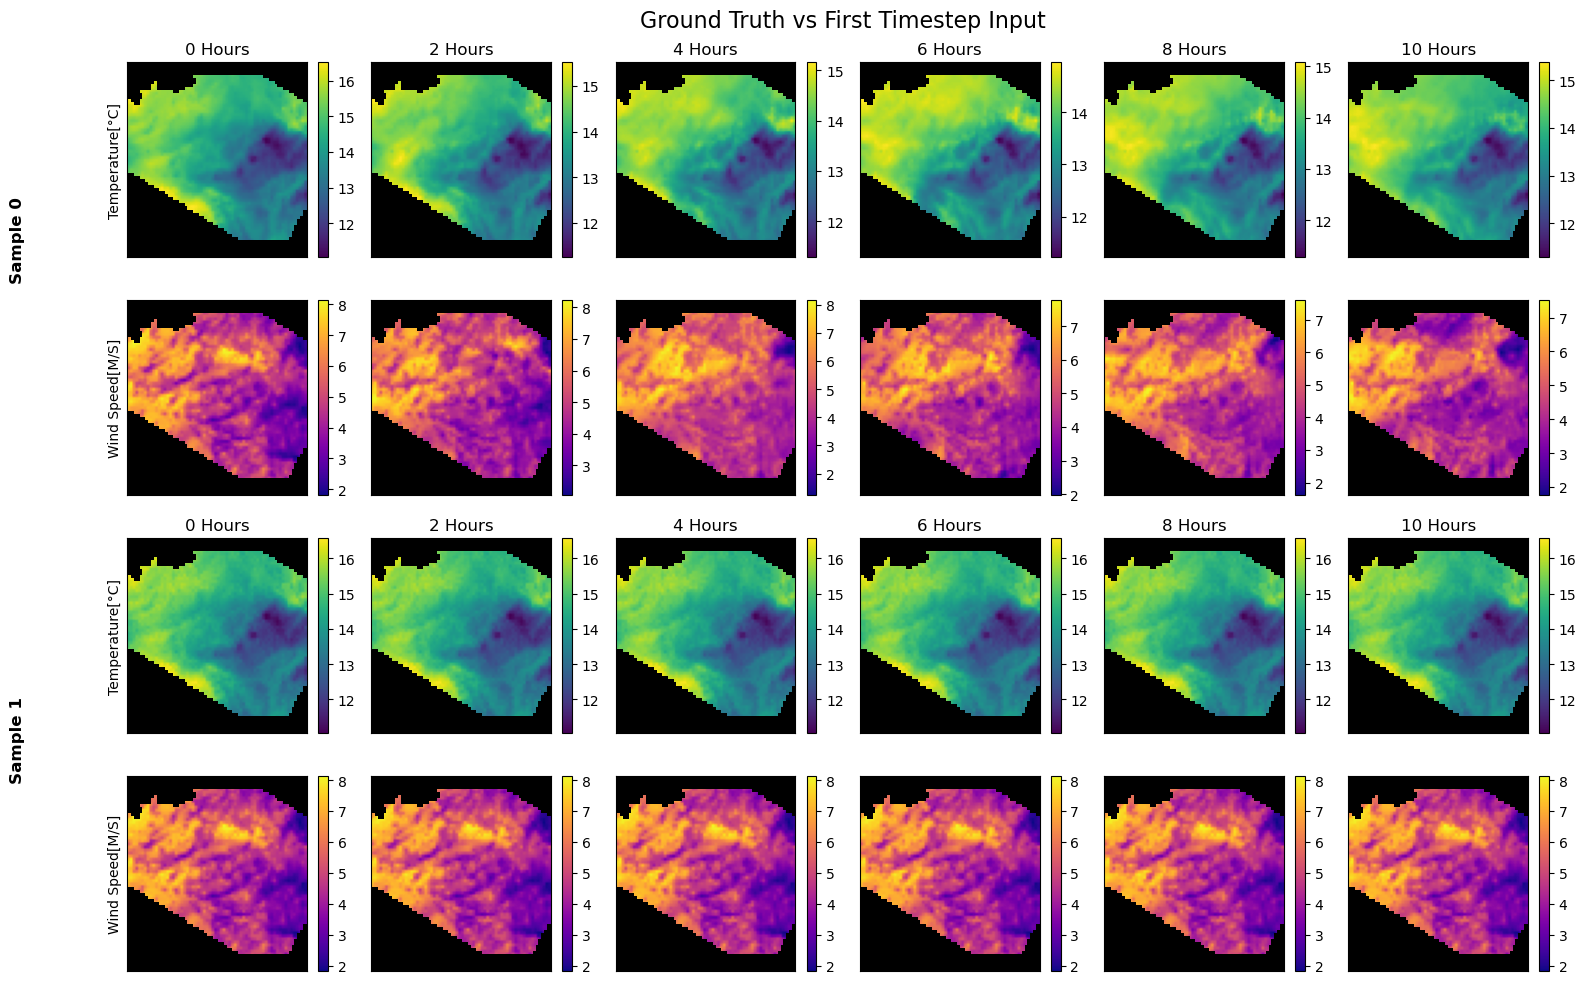

In [8]:
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)


y_star = torch.normal(A(x_star), 1e-2)*mask
y_star = y_star.squeeze(0).repeat(1, window, 1, 1)
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
comparison = torch.stack((x_star.cpu(), y_star.cpu()), dim=1).flatten(0,1).cpu()
fig = plot_sample(comparison, info, mask_cpu, samples=2, step=2, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Ground Truth vs First Timestep Input", fontsize=16)
plt.tight_layout()

In [32]:
import score
importlib.reload(score)
x_star, c_star = next(iter(testloader))
x_star, c_star = x_star[0].unsqueeze(0), c_star['context'][0].unsqueeze(0)
print(x_star.shape, c_star.shape)
x_star = x_star.to(device)
c_star = c_star.to(device)
y_star = torch.normal(A(x_star), 1e-2)*mask  
print(y_star.shape)
sde = VPSDE(score.DPSGaussianScore(y_star, mask, A=A, sde=vpsde, zeta=15.0), shape=x_star.shape).to(device)



RuntimeError: DataLoader worker (pid(s) 1903328) exited unexpectedly

In [31]:

num_samples = 3
x_preds = sde.sample(mask, shape=(num_samples,), c=c_star, steps=64, corrections=12, tau=1.5).cpu()
y_star = y_star.squeeze(0).repeat(1, window, 1, 1)
all_tensors = [x_star.detach().cpu(), y_star.detach().cpu()] + [x_preds[i] for i in range(num_samples)]
new_tensor = torch.stack(all_tensors, dim=1).flatten(0,1).cpu()

path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor, info, mask_cpu, samples=5, step=3, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Ground Truth vs First Timestep Input vs Prediction", fontsize=16)
plt.tight_layout()

100%|███████████████████████████████████████████████████| 64/64 [00:22<00:00,  2.90it/s]


RuntimeError: stack expects each tensor to be equal size, but got [1, 24, 64, 64] at entry 0 and [1, 288, 64, 64] at entry 1

torch.Size([3, 24, 64, 64]) torch.Size([3, 24, 64, 64]) torch.Size([1, 64, 64])
torch.Size([3, 12, 2, 64, 64])
torch.Size([3, 12, 2, 64, 64])
Overall RMSE: 1.981
RMSE per variable and time step: tensor([[0.5703, 0.9309, 0.9457, 1.4183, 2.0487, 2.5219, 2.0544, 1.5345, 1.3581,
         0.9907, 0.6987, 0.6695],
        [1.9995, 1.8562, 6.8570, 4.3083, 4.1207, 2.3670, 8.2596, 3.9365, 3.5577,
         2.1893, 3.9820, 6.7071]])
Metrics: {'rmse': {'per_var_time': tensor([[0.5703, 0.9309, 0.9457, 1.4183, 2.0487, 2.5219, 2.0544, 1.5345, 1.3581,
         0.9907, 0.6987, 0.6695],
        [1.9995, 1.8562, 6.8570, 4.3083, 4.1207, 2.3670, 8.2596, 3.9365, 3.5577,
         2.1893, 3.9820, 6.7071]]), 'overall': tensor(1.9812)}, 'mae': {'per_var_time': tensor([[ 0.8007,  1.4182,  1.2844,  2.1893,  3.4292,  4.2625,  3.4316,  2.5139,
          2.1570,  1.5291,  1.0259,  0.9337],
        [ 2.9793,  2.4873, 10.0378,  6.3199,  6.3465,  2.9524, 13.3387,  6.1710,
          5.5706,  3.0543,  6.1809, 10.8086]]),

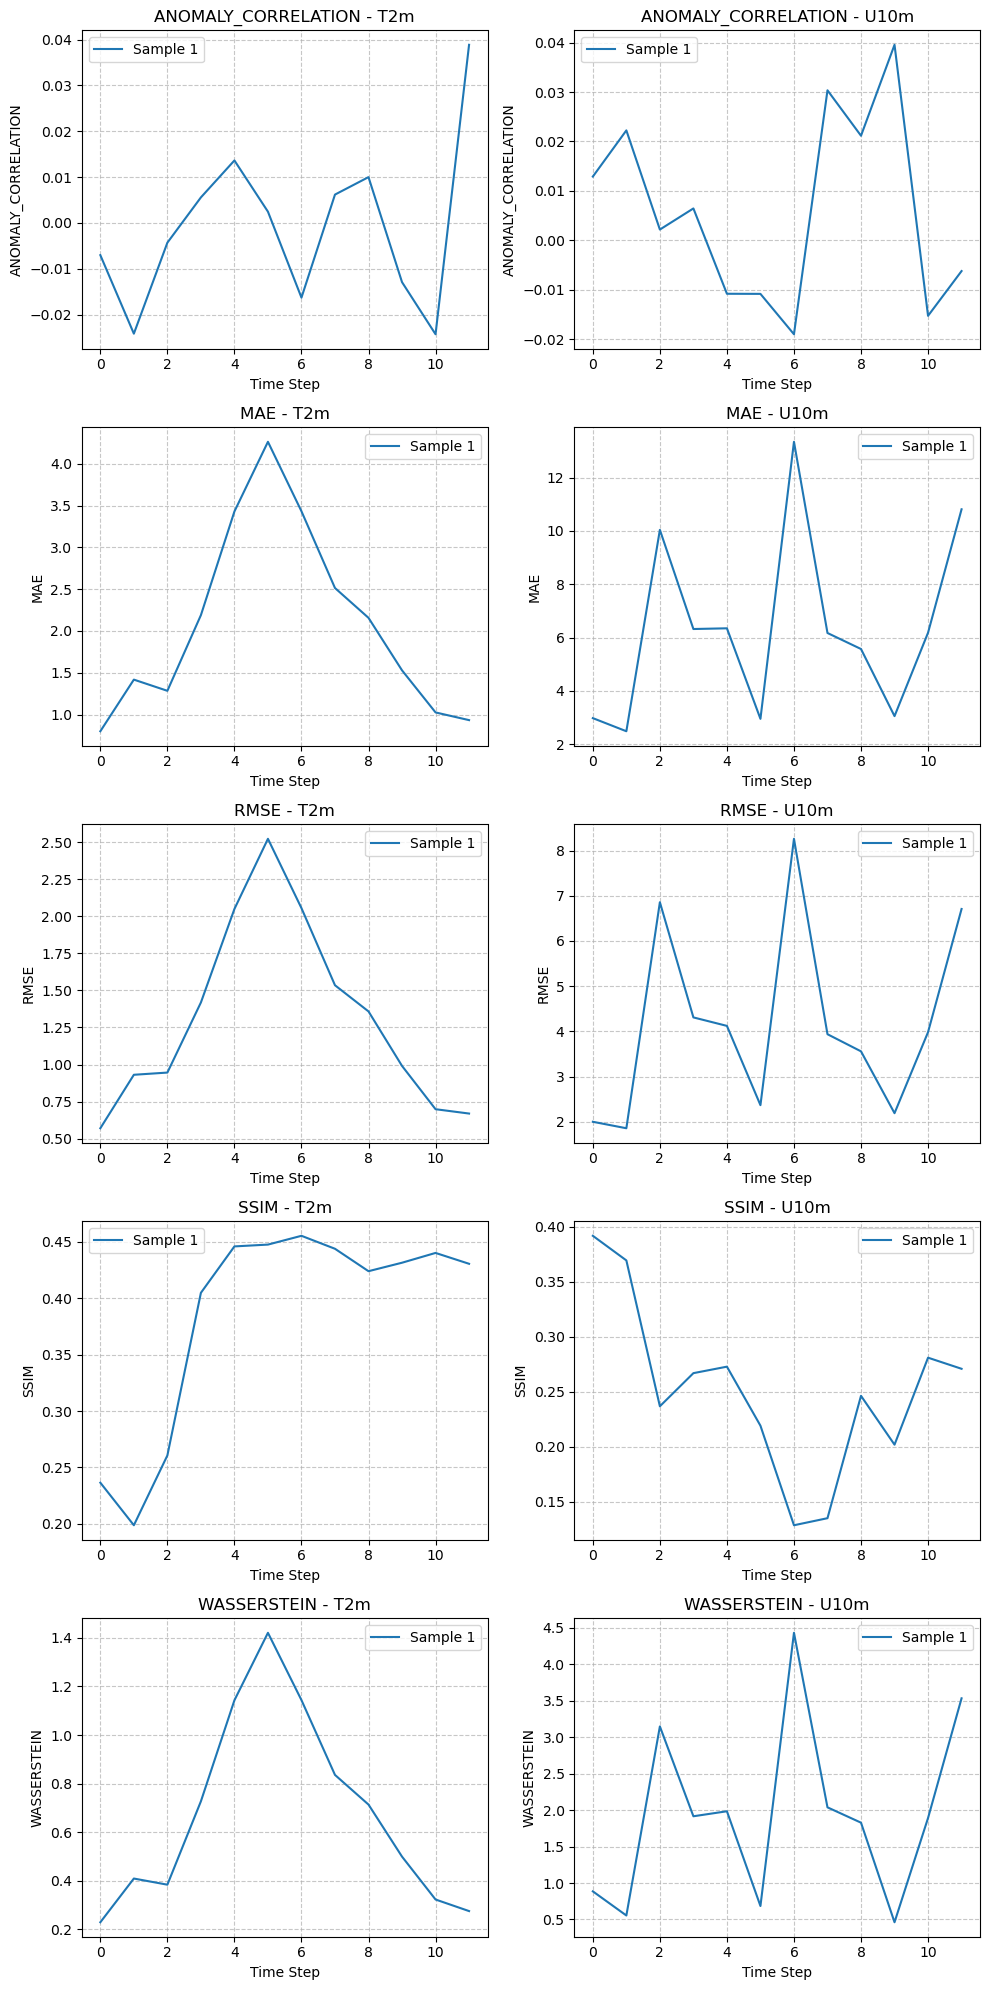

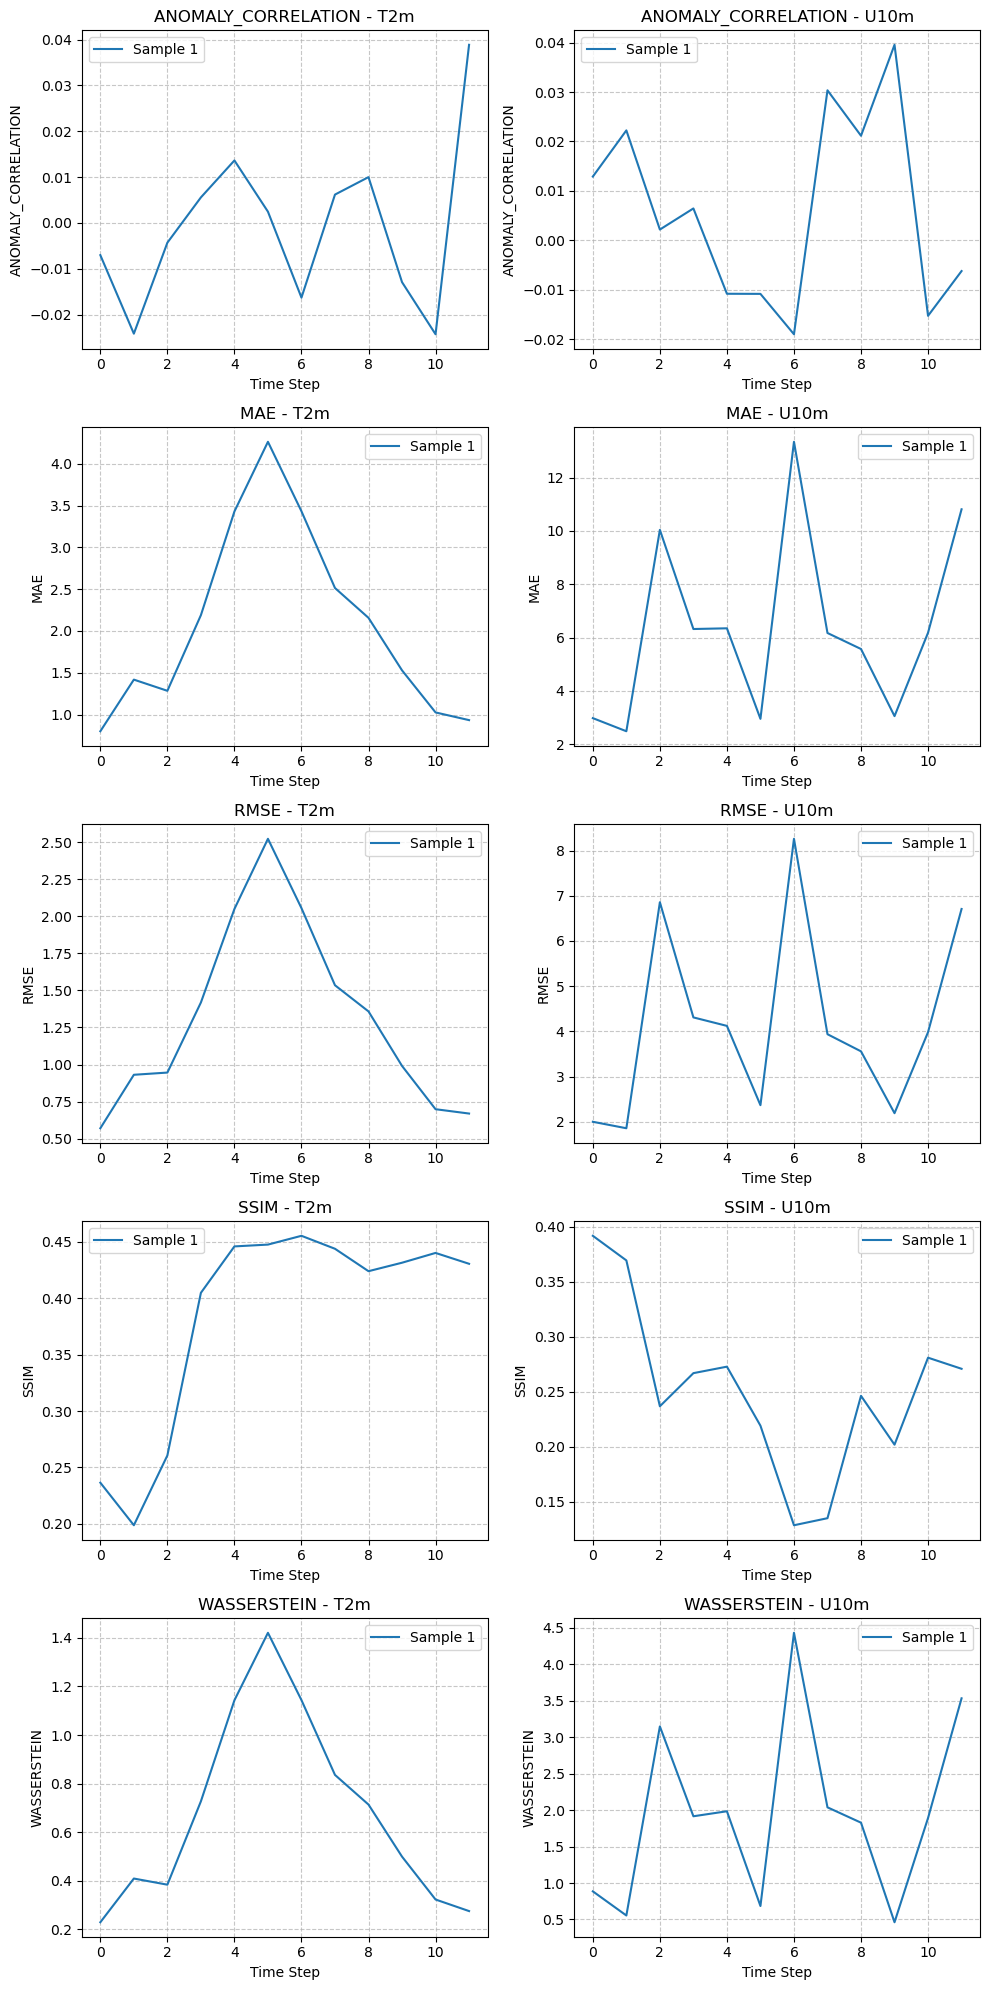

In [24]:
import metrics
importlib.reload(metrics)
preds = torch.stack([x_preds[i] for i in range(num_samples)]).squeeze(1)
gt = x_star.detach().cpu()
gt = gt.repeat(3,1,1,1)
print(preds.shape, gt.shape, mask_cpu.shape)
rmse_per_var_time, overall_rmse = metrics.calculate_rmse(preds, gt, mask_cpu)
metrics_results = metrics.calculate_metrics(preds, gt, mask_cpu)
print(f"Overall RMSE: {overall_rmse:.3f}")
print(f"RMSE per variable and time step: {rmse_per_var_time}")
print(f"Metrics: {metrics_results}")
metrics.plot_metric_comparison(metrics_results)